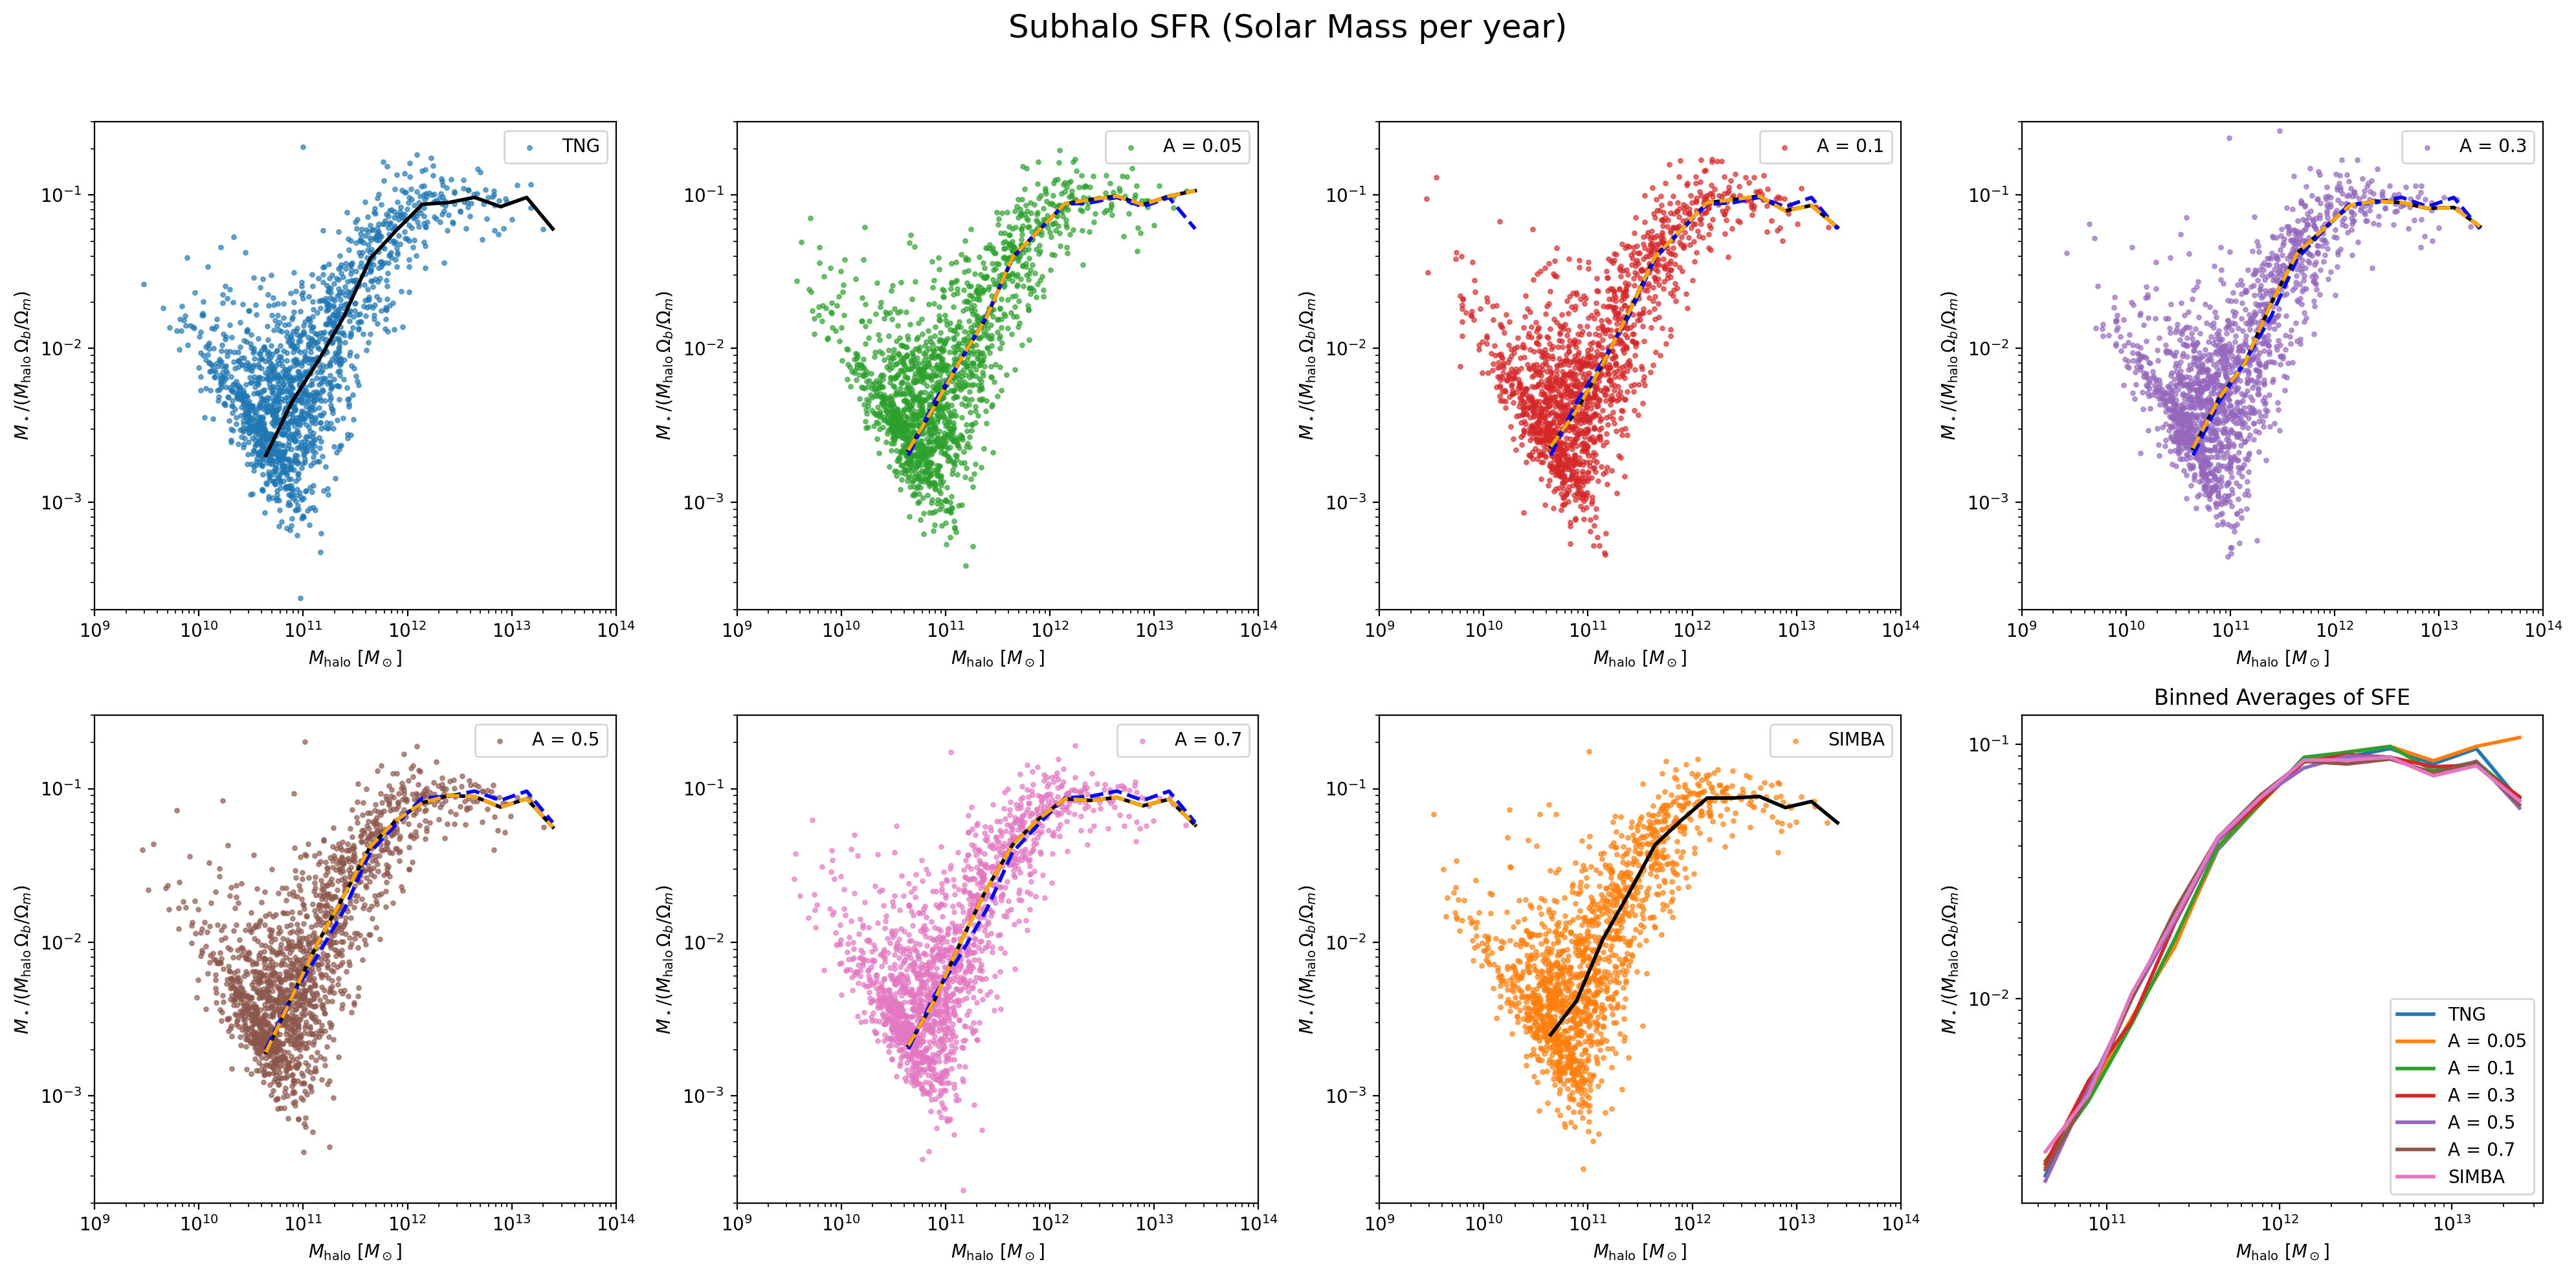

In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
h = 0.6711
omega_b_over_omega_m = 0.16

def StarFormationEfficiency(file, fof, color, name, ax, avrgs, count, bins=20):
    data = h5py.File(file, "r") 
    f = h5py.File(fof, "r") 

    Mstar_sub = f["Subhalo/SubhaloMassType"][:, 4] * 1e10 / h
    sub_to_halo = f["Subhalo/SubhaloGroupNr"][:]
    nhalo = f["Group/GroupMass"].shape[0]
    Mstar_halo = np.bincount(sub_to_halo, weights=Mstar_sub, minlength=nhalo)
    Mhalo = f["Group/GroupMass"][:] * 1e10 / h

    sfe = Mstar_halo / (Mhalo * omega_b_over_omega_m)
    
    bin_edges = np.logspace(9, 14, 21)
    bin_means, _, _ = binned_statistic(Mhalo, sfe, statistic='mean', bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    mask = bin_centers >= 3e10
    bin_centers_cut = bin_centers[mask]
    bin_means_cut = bin_means[mask]

    ax.plot(bin_centers_cut, bin_means_cut, color="black", lw=2)

    avrgs.append((bin_centers_cut, bin_means_cut))

    if name not in ["TNG", "SIMBA"]:
        ax.plot(avrgs[0][0], avrgs[0][1], color="blue", linestyle='--', lw=2)   # TNG
        ax.plot(avrgs[-1][0], avrgs[-1][1], color="orange", linestyle='--', lw=2) # SIMBA

    ax.scatter(Mhalo, sfe, s=5, label=name, alpha=0.6, color=color)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$M_{\rm halo}\ [M_\odot]$")
    ax.set_ylabel(r"$M_\star / (M_{\rm halo} \, \Omega_b / \Omega_m)$")
    ax.set_xlim(1e9, 1e14)
    ax.set_ylim(2e-4, 3e-1)

    ax.legend()
    return count

TNG = "data/Output-fidTNG_CAMELS/snap_032.hdf5"
SIMBA = "SimbaTNG-production/d7202e7--EOS-1p0/snap_032.hdf5"
runs = ["0p05","0p1","0p3","0p5","0p7"]
data = [TNG] + [f"SimbaTNG-production/d7202e7--EOS-{r}/snap_032.hdf5" for r in runs] + [SIMBA]
fof = ["data/Output-fidTNG_CAMELS/fof_subhalo_tab_032.hdf5"] + \
      [f"SimbaTNG-production/d7202e7--EOS-{r}/fof_subhalo_tab_032.hdf5" for r in runs] + \
      ["SimbaTNG-production/d7202e7--EOS-1p0/fof_subhalo_tab_032.hdf5"]
names = ["TNG", "A = 0.05", "A = 0.1", "A = 0.3", "A = 0.5", "A = 0.7", "SIMBA"]
colors = ["tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:orange"]

fig, axes = plt.subplots(2, 4, figsize=(20, 10), dpi=200)
axes = axes.flatten()
avrgs = []
count = 0

for i in range(len(data)):
    if i < len(data) - 1:
        ax = axes[i]  # first 6 subplots for TNG + EOS
    else:
        ax = axes[6]  # SIMBA in its own subplot
    count = StarFormationEfficiency(data[i], fof[i], colors[i], names[i], ax, avrgs, count)

ax_avg = axes[7]
for i, (centers, means) in enumerate(avrgs):
    ax_avg.plot(centers, means, lw=2, label=names[i])
ax_avg.set_xscale('log')
ax_avg.set_yscale('log')
ax_avg.set_xlabel(r"$M_{\rm halo}\ [M_\odot]$")
ax_avg.set_ylabel(r"$M_\star / (M_{\rm halo} \, \Omega_b / \Omega_m)$")
ax_avg.set_title("Binned Averages of SFE")
ax_avg.legend()

fig.suptitle("Subhalo SFR (Solar Mass per year)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()